# mecab colab에 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [4]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [6]:
#! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#ls
#cd /content/Mecab-ko-for-Google-Colab
#! bash install_mecab-ko_on_colab190912.sh

# imports

In [7]:
import konlpy
from konlpy.tag import Mecab

In [8]:
mecab = Mecab()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
from sklearn.model_selection import train_test_split

In [66]:
from sklearn.linear_model import LogisticRegression

In [29]:
from gensim.models import word2vec

2021-04-23 05:20:53,039 : INFO : 'pattern' package not found; tag filters are not available for English


In [85]:
from gensim.models import Doc2Vec

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# 진행 상황 나오는 log 설정
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
   level=logging.INFO)

# 뉴스기사 불러오기

In [184]:
# 기사 excel 파일 load
url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/C01_KM_Labeled.xlsx'
news = pd.read_excel(url, header=1, usecols=['Code', 'Date', 'Journal', 'Title','Text','URL', 'Sentiment'])

In [233]:
# 중복 제거 (labeling에 '중복' 적힌것 있음)
news = news.drop_duplicates(subset=['Date', 'Text'], keep='first')

In [234]:
# 기사 본문 기자의 이메일 OOOO @ asdfas.com 에서 @ 전 까지의 내용으로 저장
for i in range(len(news)):
    news.iloc[i]['Text'] = news.iloc[i]['Text'].split(sep='@')[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [235]:
# 파일 덮어쓰고 다시 불러오기
news.to_excel("article.xlsx")
news = pd.read_excel('/content/article.xlsx', header=0, usecols=['Code', 'Date', 'Journal', 'Title','Text', 'Sentiment'])

# word2vec

In [ ]:
# https://devtimes.com/nb-text-classification-word2vec

In [22]:
news[:3]

,Code,Date,Journal,Title,Text,Sentiment
0,5930,2021.04.13 17:50,파이낸셜뉴스,"삼성전자 사내식당 2곳, 신세계·풀무원이 운영한다",삼성전자가 사내식당 2곳에 대해 실시한 외부 급식업체 경쟁입찰에서 '신세계푸드'와 ...,1
1,5930,2021.04.13 03:11,파이낸셜뉴스,"삼성전자 초청, 美 '반도체 회담'‥백악관 ""즉각적 결정 없을 것""",조 바이든 미국 대통령이 12일(현지시간) '반도체 공급망 강화 온라인 회담'에 참...,-1
2,5930,2021.04.08 14:55,파이낸셜뉴스,"[특징주]로보스타, 삼성-LG전자 미래 신성장 동력 ‘로봇산업’ 육성 ...",[파이낸셜뉴스]미래 신성장 동력인 로봇산업에 삼성전자와 LG전자가 힘을 쏟을 것이란...,1


In [188]:
tag_classes = ['NNP', 'NNG', 'VV+EC', 'XSV+EP']   # 추출할 품사 종류
stopwords = [np.nan, '삼성전자', '삼성', '인텔', '데일리', '기자', 'LG전자', 'LG', 'YG', 'JYP', '뉴스', '파이낸셜'] # 불용어 처리
Text = []
for main in news['Text']:    # 표에서 메인 기사 개수만큼 반복
    temp=[]                     # 임시저장할 배열
    for word in mecab.pos(main):        # 기사에서 (단어, 품사) 형태의 word 뽑아내서 하나씩 사용
        if word[1] in tag_classes:      # word[1]=>품사 가 추출할 품사종류에 들어 있으면
            if word[0] not in stopwords:    # 불용어에 들어있지 않으면
                temp.append(word[0])           # temp배열에 단어=> word[0] 추가
    Text.append(temp)         # test 셋 배열에 저장

In [189]:
len(Text)

1531

* num_fratures : 각 단어에 대한 임베딩된 벡터의 차원을 정한다.
* minwordcount : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않는다.
* num_workers : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않는다.
* context : word2vec을 수행하기 위한 컨텍스트 윈도우 크기를 지정한다.
* downsampling : word2vec 학습을 수행할 때 더 빠른 학습을 위해 정답 단어 라벨에 대한 다운샘플링 비율을 지정한다. (보통 0.001이 좋은 성능을 낸다고 한다)

In [220]:
# 학습 시 필요한 하이퍼 파라미터
num_features = 1500    # 워드 백터 특정값 수
min_word_count = 2   # 단어에 대한 최소 빈도 수
num_workers = 4       # 프로세스 개수
context = 5         # 컨텍스트 윈도우 크기, 앞 뒤 5개씩 관련
downsampling = 1e-3   # 다운 샘플링 비율

In [ ]:
model = word2vec.Word2Vec(Text,
                        workers=num_workers,
                        size=num_features,
                        min_count=min_word_count,
                        window=context,
                        sample=downsampling) #epoch= 횟수 추가할수있음

In [ ]:
# 모델의 하이퍼파라미터를 설정한 내용을 모델 이름에 담는다면 나중에 참고하기 용이하다.
# 모델을 저장하면 Word2Vec.load()를 통해 다시 사용할 수 있다.
model_name = "word2_model"
model.save(model_name)

* words : 단어의 모음인 하나의 리뷰가 들어간다.
* model : word2vec 모델을 넣는 공이며, 우리가 학습한 word2vec 모델이 들어간다.
* num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수를 뜻한다.

하나의 벡터를 만드는 과정을 빠르게 하기 위해 np.zeros를 사용해 미리 모두 0값을 가지는 벡터를 만든다. 그리고 문장의 단어가 모델 단어사전에 속하는지 보기 위해 model.wv.index2word를 set객체로 생성해서 index2word_set 변수에 할당한다. 다음 반복문을 통해 리뷰를 구성하는 단어에 대해 임베딩된 벡터가 있는 단어 벡터의 합을 구하고 사용한 단어의 전체 개수로 나누어 평균 벡터의 값을 구한다.


In [193]:
def get_features(words, model, num_features):
    # 출력 벡터 초기화
    feature_vector = np.zeros((num_features), dtype=np.float32)
    
    num_words = 0
    # 어휘 사전 준비
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        if w in index2word_set:
            num_words = 1
            # 사전에 해당하는 단어에 대해 단어 벡터를 더함
            feature_vector = np.add(feature_vector, model[w])
            
    # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
    feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

* news : 학습 데이터인 전체 리뷰 데이터를 입력
* model : word2vec 모델을 입력
* num_features : word2vec으로 임베딩할 때 정했던 벡터의 차원 수

In [194]:
def get_dataset(news, model, num_features):
    dataset = list()
    
    for s in news:
        dataset.append(get_features(s, model, num_features))
        
    NewsFeatureVecs = np.stack(dataset)
    return NewsFeatureVecs

In [223]:
test_data_vecs = get_dataset(Text, model, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [224]:
len(test_data_vecs)

1531

In [225]:
X = test_data_vecs
y = np.array(news['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [ ]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1200)
log_reg.fit(X_train, y_train)

In [227]:
log_reg.score(X_train, y_train)

0.625

In [228]:
log_reg.score(X_test, y_test)

0.6091205211726385

In [ ]:
x = range(100, 2000, 100)
test_score = []
train_score = []
for i in x:
    log_reg = LogisticRegression(class_weight='balanced', max_iter=i)
    log_reg.fit(X_train, y_train)
    train_score.append(log_reg.score(X_train, y_train))
    test_score.append(log_reg.score(X_test, y_test))

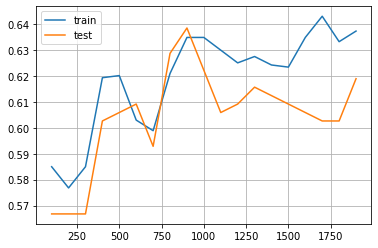

In [230]:
plt.plot(x, train_score, label='train')
plt.plot(x, test_score, label='test')
plt.grid()
plt.legend()
plt.show()

In [46]:
## 라벨링 안되어 있는거 하는 순서
# test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)
# test_news = list(test_data['Text'])
# test_sentences = []
# for review in test_review:
#     test_sentences.append(news.split())
#test_data_vecs = get_dataset(test_sentences, model, num_features)
#test_predicted = log_reg.predict(test_data_vecs)

In [205]:
url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/C01_KM_NotLabeled.xlsx'
test_data = pd.read_excel(url, header=0, usecols=['Code', 'Date', 'Journal', 'Title','Text','URL', 'Sentiment'])
test_news = list(test_data['Text'])

In [206]:
tag_classes = ['NNP', 'NNG', 'VV+EC', 'XSV+EP']   # 추출할 품사 종류
stopwords = ['삼성전자', '삼성', '인텔', '데일리', '기자', 'LG전자', 'LG', 'YG', 'JYP', '뉴스', '파이낸셜'] # 불용어 처리
Test_text = []
for main in test_news:    # 표에서 메인 기사 개수만큼 반복
    temp=[]                     # 임시저장할 배열
    for word in mecab.pos(main):        # 기사에서 (단어, 품사) 형태의 word 뽑아내서 하나씩 사용
        if word[1] in tag_classes:      # word[1]=>품사 가 추출할 품사종류에 들어 있으면
            if word[0] not in stopwords:    # 불용어에 들어있지 않으면
                temp.append(word[0])           # temp배열에 단어=> word[0] 추가
    Test_text.append(temp)         # test 셋 배열에 저장

In [232]:
test_data_vecs = get_dataset(Test_text, word2vec.Word2Vec.load('/content/word2_model'), num_features) # num_features=600

2021-04-23 07:37:05,218 : INFO : loading Word2Vec object from /content/word2_model
2021-04-23 07:37:05,244 : INFO : loading wv recursively from /content/word2_model.wv.* with mmap=None
2021-04-23 07:37:05,247 : INFO : loading vectors from /content/word2_model.wv.vectors.npy with mmap=None
2021-04-23 07:37:05,271 : INFO : setting ignored attribute vectors_norm to None
2021-04-23 07:37:05,274 : INFO : loading vocabulary recursively from /content/word2_model.vocabulary.* with mmap=None
2021-04-23 07:37:05,277 : INFO : loading trainables recursively from /content/word2_model.trainables.* with mmap=None
2021-04-23 07:37:05,280 : INFO : loading syn1neg from /content/word2_model.trainables.syn1neg.npy with mmap=None
2021-04-23 07:37:05,313 : INFO : setting ignored attribute cum_table to None
2021-04-23 07:37:05,315 : INFO : loaded /content/word2_model
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed i

In [213]:
sentiment = log_reg.predict(test_data_vecs)

In [216]:
test_data['Sentiment'] = sentiment

In [219]:
test_data[-10:]

,Code,Date,Journal,Title,Text,URL,Sentiment
6391,66570,2020.10.14 10:10,서울경제,"""노인돌봄, 디지털로 진화한다""···LG유플러스-한컴위드-LG전자 협업",시니어케어 산업 함께 성장하는 생태계 조성박종욱(왼쪽부터) LG유플러스 CSO 전무...,https://finance.naver.com/item/news_read.nhn?a...,1
6392,66570,2020.10.13 17:38,한국경제,"LG전자, ‘LG 퓨리케어 정수기’ 2020년도 9관왕 수상 기념 특별...",브랜드·환경·디자인 등 다분야 수상 석권… 총 9개 부문 수상▲사진 제공 : LG전...,https://finance.naver.com/item/news_read.nhn?a...,1
6393,66570,2020.10.13 11:11,서울경제,"LG전자 로봇청소기 광고영상 1,000만뷰 돌파",물걸레 전용 로봇청소기 ‘코드제로 M9 씽큐’편리함 소개 광고들 잇따라 ‘천만 조회...,https://finance.naver.com/item/news_read.nhn?a...,1
6394,66570,2020.10.13 11:01,헤럴드경제,LG전자 물걸레 전용 로봇청소기 광고 잇따라 1000만뷰,더럽히는 로봇과 코드제로 M9 씽큐 청소 대결박상현 캐스터와 김동준 해설가의 중계로...,https://finance.naver.com/item/news_read.nhn?a...,0
6395,66570,2020.10.13 11:01,이데일리,"LG전자, 로봇청소기 광고영상 1000만뷰 돌파",[이데일리 신민준 기자] LG전자(066570)가 최근 출시한 물걸레 전용 로봇청소...,https://finance.naver.com/item/news_read.nhn?a...,0
6396,66570,2020.10.12 15:48,이데일리,"""펜트업 수요 폭발""…삼성·LG전자, TV기술 경쟁 후끈","LG, 오는 14일부터 VVIP 대상 롤러블TV 예약 판매삼성, 미니LED TV로 ...",https://finance.naver.com/item/news_read.nhn?a...,1
6397,66570,2020.10.12 15:37,머니투데이,베트남에 전장 R&D센터 확대하는 LG전자…흑자전환 '드라이브',"[머니투데이 박소연 기자] [3분기, 상반기 부진 딛고 적자폭 크게 줄어…내년 2분...",https://finance.naver.com/item/news_read.nhn?a...,1
6398,66570,2020.10.12 14:00,서울경제,"""LG전자, 올 홈엔터 최고 브랜드""",英 전문매체 선정···韓기업 유일TV 종합평가서도 상위권 싹쓸이호주 시드니에 위치한...,https://finance.naver.com/item/news_read.nhn?a...,1
6399,66570,2020.10.12 11:23,헤럴드경제,"LG전자, 英서 최고 ‘홈엔터테인먼트 브랜드’",유력 소비자 전문매체 ‘위치’ 선정영국 유력 소비자 전문매체 ‘위치’로부터 최고 평...,https://finance.naver.com/item/news_read.nhn?a...,1
6400,66570,2020.10.12 10:39,서울경제,"LG전자, 탈모인 100명에 ‘LG 프라엘 메디헤어’ 쏜다",이달 말 정식 출시 앞둔헬맷 탈모 치료용 의료기기식약처 허가·美 FDA 인가 획득“...,https://finance.naver.com/item/news_read.nhn?a...,1


# Doc2vec

In [82]:
# Doc2vec 파라미터 설명
# https://roboreport.co.kr/doc2vec-%ED%9B%88%EB%A0%A8-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%84%A4%EB%AA%85/

In [110]:
from gensim.models.doc2vec import TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(Text)]

In [ ]:
model_feat_size = 600
model = Doc2Vec(documents, min_count=2, window=10, vector_size=model_feat_size, neagtive=5, sample=1e-4, workers=4) 

In [112]:
model_name = "Doc2_model"
model.save(model_name)

2021-04-23 06:08:40,368 : INFO : saving Doc2Vec object under Doc2_model, separately None
2021-04-23 06:08:40,788 : INFO : saved Doc2_model


In [113]:
test_data_vecs = get_dataset(Text, model.wv.load('/content/Doc2_model'), num_features)

2021-04-23 06:09:08,881 : INFO : loading Word2VecKeyedVectors object from /content/Doc2_model
2021-04-23 06:09:09,233 : INFO : loading vocabulary recursively from /content/Doc2_model.vocabulary.* with mmap=None
2021-04-23 06:09:09,235 : INFO : loading trainables recursively from /content/Doc2_model.trainables.* with mmap=None
2021-04-23 06:09:09,238 : INFO : loading wv recursively from /content/Doc2_model.wv.* with mmap=None
2021-04-23 06:09:09,240 : INFO : loading docvecs recursively from /content/Doc2_model.docvecs.* with mmap=None
2021-04-23 06:09:09,242 : INFO : loaded /content/Doc2_model


In [115]:
len(test_data_vecs)

1226

In [116]:
X = test_data_vecs
y = np.array(news['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [117]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1200)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
log_reg.score(X_train, y_train)

0.6459183673469387

In [119]:
log_reg.score(X_test, y_test)

0.6504065040650406

In [ ]:
x = range(100, 2000, 100)
test_score = []
train_score = []
for i in x:
    log_reg = LogisticRegression(class_weight='balanced', max_iter=i)
    log_reg.fit(X_train, y_train)
    train_score.append(log_reg.score(X_train, y_train))
    test_score.append(log_reg.score(X_test, y_test))

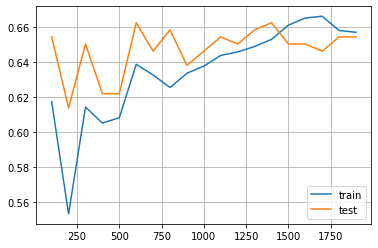

In [122]:
plt.plot(x, train_score, label='train')
plt.plot(x, test_score, label='test')
plt.grid()
plt.legend()
plt.show()

# TF-IDF

In [47]:
# https://chan-lab.tistory.com/27
# https://devtimes.com/nb-text-classification-tf-idf

TF-IDF : TF(Term Frequency, 단어의 빈도), IDF(역문서 빈도, Inverse Document Frequency) 쉽게 말하자면 문장에서 단어의 빈도수를 계산하되 너무 자주 등장하는 단어는 크게 의미를 두지 않도록 가중치를 낮게 주자는 의미.



* min_df : 설정한 값보다 특정 토큰의 df값이 더 적게 나오면 벡터화 과정에서 제거
* analyzer : 분석하기 위한 기준 단위(word:단어 하나를 단위로, char:문자 하나를 단위로)
* sublinear_tf : 문서의 단어 빈도 수에 대한 스무딩(smoothing) 여부
* ngram_range : 빈도의 기본 단위를 설정할 n-gram 범위
* max_features : 각 벡터의 최대 길이


In [123]:
vectorizer = TfidfVectorizer(
            min_df=0.0,
            analyzer="word",
            sublinear_tf=True,
            ngram_range=(1,3),
            max_features=5000
        )

In [157]:
vectorizer.fit(words)
X = vectorizer.transform(list(news['Text']))

In [ ]:
vectorizer.vocabulary_

In [153]:
y = np.array(news['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42)
log_reg = LogisticRegression(class_weight = 'balanced')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [154]:
log_reg.score(X_train, y_train)

0.923469387755102

In [155]:
log_reg.score(X_test, y_test)

0.7560975609756098